In [1]:
# Import the necessary libraries
import pandas as pd
import numpy as np
from sklearn import linear_model
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Linear regression: the algorithm determines the parameters of an assumed linear relationship
# between the responsible variable 'Y' and the explantory variable 'X' in the form of
# Y = aX + b, where a & b are scalars.
# Y & X are multidemensional, a is a matrix and b is a vector
# the goal of the algorithm is to identify the optimal values for the parameters a & b 
# to minimize the mean squared error between the model estimates and the training set data
# Hopefully the model will help predict the values of 'Y' given the future values of 'X'

In [3]:
# Read 2015 game log data into Pandas DataFrame
input_df = pd.read_table('GL2015.TXT', sep=',', header=None)

In [12]:
# Prep read in data 
# Create a method to Add column headers to the the DataFrame 

def rename_col(input_df):
    input_df.rename(columns = {2:'DayOfWeek' , 3:'Visiting Team', 4:'VisitorTeam League', 6: 'Home Team', 
                               7:'HomeTeam League', 9:'Runs Visitor', 10:'Runs Home'}, inplace=True)
    return input_df

In [13]:
# Now using that method we can add column headers and check values
input_df = rename_col(input_df)

In [14]:
input_df.head()

,0,1,DayOfWeek,Visiting Team,VisitorTeam League,5,Home Team,HomeTeam League,8,Runs Visitor,...,151,152,153,154,155,156,157,158,159,160
0,20150405,0,Sun,SLN,NL,1,CHN,NL,1,3,...,David Ross,2,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y
1,20150406,0,Mon,MIN,AL,1,DET,AL,1,0,...,Nick Castellanos,5,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y
2,20150406,0,Mon,CLE,AL,1,HOU,AL,1,0,...,Jed Lowrie,6,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y
3,20150406,0,Mon,CHA,AL,1,KCA,AL,1,1,...,Alex Rios,9,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,Alex Rodriguez,10,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y


In [17]:
# Cretae 2 New Columns to indicate whether the home team or visting team won
# Input Current DataFrame
# Output Ammended DataFrame

def add_new_cols(input_df):
    input_df['Home Win'] = (input_df['Runs Home'] > input_df['Runs Visitor'])
    input_df['Visitor Win'] = (input_df['Runs Visitor'] > input_df['Runs Home'])
    return input_df

In [18]:
# add new columns to input_df
input_df = add_new_cols(input_df)

In [19]:
# Review dataframe and inspect new columns
input_df.head()

,0,1,DayOfWeek,Visiting Team,VisitorTeam League,5,Home Team,HomeTeam League,8,Runs Visitor,...,153,154,155,156,157,158,159,160,Home Win,Visitor Win
0,20150405,0,Sun,SLN,NL,1,CHN,NL,1,3,...,lestj001,Jon Lester,1,lastt001,Tommy La Stella,4,NaN,Y,False,True
1,20150406,0,Mon,MIN,AL,1,DET,AL,1,0,...,avila001,Alex Avila,2,iglej001,Jose Iglesias,6,NaN,Y,True,False
2,20150406,0,Mon,CLE,AL,1,HOU,AL,1,0,...,rasmc001,Colby Rasmus,7,marij002,Jake Marisnick,8,NaN,Y,True,False
3,20150406,0,Mon,CHA,AL,1,KCA,AL,1,1,...,peres002,Salvador Perez,2,infao001,Omar Infante,4,NaN,Y,True,False
4,20150406,0,Mon,TOR,AL,1,NYA,AL,1,6,...,drews001,Stephen Drew,4,gregd001,Didi Gregorius,6,NaN,Y,False,True


In [23]:
# Create function to Summarize the Game log data set for analysis
# Using the group by method create a new variable "home_group" with an aggregate dataframe by Home Team 
# 

def proc_home_team_data(input_df):
    # group by home team
    home_group = input_df.groupby(input_df['Home Team'])
    
    #Summarize Stat Data
    home_df = home_group[['Runs Visitor', 'Runs Home', 'Home Win']].apply(sum)
    home_df['Home Games'] = home_group['Home Win'].count()
    home_df.rename(columns = {'Runs Visitor':'Runs by Visitor', 'Runs Home':'Runs at Home', 
                              'Home Win':'Wins at Home'}, inplace=True)
    home_df['RD at Home'] = home_df['Runs at Home'] - home_df['Runs by Visitor']
    home_df.index.rename('Team', inplace=True)
    home_df.reset_index(inplace=True)
    
    return home_df

In [24]:
home_df = proc_home_team_data(input_df)

home_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home
0,ANA,298.0,320.0,49.0,81,22.0
1,ARI,372.0,366.0,39.0,81,-6.0
2,ATL,359.0,286.0,42.0,81,-73.0
3,BAL,353.0,408.0,49.0,81,55.0
4,BOS,383.0,433.0,43.0,81,50.0


In [25]:
def proc_visiting_team_data(input_df):
    # Group by Visiting Team
    visit_group = input_df.groupby(input_df['Visiting Team'])
    
    #Summarize Stat Data 
    visit_df = visit_group[['Runs Visitor', 'Runs Home', 'Visitor Win']].apply(sum)
    visit_df['Road Games'] = visit_group['Visitor Win'].count()
    visit_df.rename(columns = {'Runs Visitor':'Runs as Visitor', 'Runs Home':'Runs by Home', 
                               'Visitor Win':'Wins as Visitor'}, inplace=True)
    visit_df['RD as Visitor'] = visit_df['Runs as Visitor'] - visit_df['Runs by Home']
    visit_df.index.rename('Team', inplace=True)
    visit_df.reset_index(inplace=True)
    
    return visit_df

In [26]:
visit_df = proc_visiting_team_data(input_df)

visit_df.head()

,Team,Runs as Visitor,Runs by Home,Wins as Visitor,Road Games,RD as Visitor
0,ANA,341.0,377.0,36.0,81,-36.0
1,ARI,354.0,341.0,40.0,81,13.0
2,ATL,287.0,401.0,25.0,81,-114.0
3,BAL,305.0,340.0,32.0,81,-35.0
4,BOS,315.0,370.0,35.0,81,-55.0


In [30]:
def merge_data_frames(home_df, visit_df):
    # Create 'Y' response and 'X' explanatory variables
    overall_df = home_df.merge(visit_df, how='outer', left_on='Team', right_on='Team')
    overall_df['RD'] = overall_df['RD at Home'] + overall_df['RD as Visitor']
    overall_df['Win Pct'] = (overall_df['Wins at Home']+overall_df['Wins as Visitor'])/(overall_df['Home Games']+overall_df['Road Games'])
    
    return overall_df

In [31]:
overall_df = merge_data_frames(home_df, visit_df)

In [32]:
overall_df.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home,Runs as Visitor,Runs by Home,Wins as Visitor,Road Games,RD as Visitor,RD,Win Pct
0,ANA,298.0,320.0,49.0,81,22.0,341.0,377.0,36.0,81,-36.0,-14.0,0.524691
1,ARI,372.0,366.0,39.0,81,-6.0,354.0,341.0,40.0,81,13.0,7.0,0.487654
2,ATL,359.0,286.0,42.0,81,-73.0,287.0,401.0,25.0,81,-114.0,-187.0,0.413580
3,BAL,353.0,408.0,49.0,81,55.0,305.0,340.0,32.0,81,-35.0,20.0,0.500000
4,BOS,383.0,433.0,43.0,81,50.0,315.0,370.0,35.0,81,-55.0,-5.0,0.481481


In [52]:
# Join all constructed methods for quick processing and compiling of summary data for all Game Logs

def extract_linear_reg_inputs(input_df):
    # Rename Columns
    input_df = rename_col(input_df)
    
    # Add new columns
    input_df = add_new_cols(input_df)
    
    # Group and process data by home team
    home_df = proc_home_team_data(input_df)
    
    # Group and process data by visiting team
    visit_df = proc_visiting_team_data(input_df)
    
    # Merge home and visitor dataframes
    overall_df = merge_data_frames(home_df, visit_df)
    
    return overall_df


In [56]:
# Collecting and Building the trainging set data. (2011-2015)

train_run_diff = np.empty([0,1])
train_win_pct = np.empty([0,1])

# loop through files to build complete dataframe of identified files

for year in range(2011, 2016):
    # Construct log of file data
    log_file = 'GL'+str(year)+'.TXT'
    
    # read logged file data into dataframe
    df = pd.read_table(log_file, sep=',', header=None)
    
    # Extract relevant data into another dataframe
    df_proc = extract_linear_reg_inputs(df)
    
    # add to training set
    train_run_diff = np.vstack([train_run_diff, df_proc['RD'].values.reshape([-1,1])])
    train_win_pct = np.vstack([train_win_pct, df_proc['Win Pct'].values.reshape([-1,1])])
    

In [71]:
df_proc.head()

,Team,Runs by Visitor,Runs at Home,Wins at Home,Home Games,RD at Home,Runs as Visitor,Runs by Home,Wins as Visitor,Road Games,RD as Visitor,RD,Win Pct
0,ANA,298.0,320.0,49.0,81,22.0,341.0,377.0,36.0,81,-36.0,-14.0,0.524691
1,ARI,372.0,366.0,39.0,81,-6.0,354.0,341.0,40.0,81,13.0,7.0,0.487654
2,ATL,359.0,286.0,42.0,81,-73.0,287.0,401.0,25.0,81,-114.0,-187.0,0.413580
3,BAL,353.0,408.0,49.0,81,55.0,305.0,340.0,32.0,81,-35.0,20.0,0.500000
4,BOS,383.0,433.0,43.0,81,50.0,315.0,370.0,35.0,81,-55.0,-5.0,0.481481


In [54]:
lin_regr = linear_model.LinearRegression(fit_intercept=True)

In [57]:
lin_regr.fit(train_run_diff, train_win_pct)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [75]:
# Access and display current model prarmeters
print('Slope (a) =', float(lin_regr.coef_), ' Intercept (b) = ', float(lin_regr.intercept_))

# Get Regression Score (R-Squared)
r_squared = lin_regr.score(train_run_diff, train_win_pct)
print('R-squared for linear fit = ', r_squared)

Slope (a) = 0.0006467879497387064  Intercept (b) =  0.4999936726219291
R-squared for linear fit =  0.8625081265362202


In [74]:
# Get Regression Score (R-Squared)
r_squared = lin_regr.score(train_run_diff, train_win_pct)
print('R-squared for linear fit = ', r_squared)

R-squared for linear fit =  0.8625081265362202


In [77]:
x_ax = np.array(range(int(np.min(train_run_diff)), int(np.max(train_run_diff)))).reshape(-1,1)
y_ax = lin_regr.coef_ * x_ax + lin_regr.intercept_

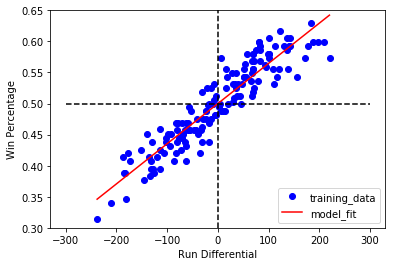

In [89]:
plt.plot(train_run_diff, train_win_pct, 'bo', label='training_data')
plt.plot(x_ax, y_ax, 'r', label='model_fit')
plt.ylim([0.30, 0.65])
plt.plot([-300, 300], [0.5, 0.5], 'k--')
plt.plot([0,0], [0.30, 0.65], 'k--')
plt.xlabel('Run Differential')
plt.ylabel('Win Percentage')
plt.legend(loc='lower right')
plt.show()

In [92]:
log_fileTest = 'GL2016.TXT'
dfTest = pd.read_table(log_fileTest, sep=',', header=None)
df_procTest = extract_linear_reg_inputs(dfTest)
test_run_diff = df_procTest['RD'].values.reshape([-1,1])
test_win_pct = df_procTest['Win Pct'].values.reshape([-1,1])

In [93]:
# Predict outcomes using regression model
predict_win_pct = lin_regr.predict(test_run_diff)

In [103]:
mean_abs_error_test = np.mean(np.abs(predict_win_pct - test_win_pct))
print('Percentage error on test set = ',  100. * mean_abs_error_test, '%')

model_fit_train = lin_regr.predict(train_run_diff)
mean_abs_error_training = np.mean(np.abs(model_fit_train - train_win_pct))
print('Percentage error on training set = ',  100. * mean_abs_error_training, '%')

Percentage error on test set =  2.096802895798953 %
Percentage error on training set =  2.0550910528614867 %


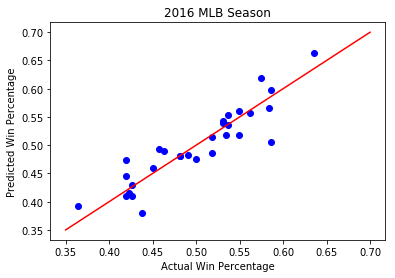

In [108]:
plt.plot(test_win_pct, predict_win_pct, 'bo' )
plt.plot([0.35,0.7], [0.35, 0.70], 'r')
plt.xlabel('Actual Win Percentage')
plt.ylabel('Predicted Win Percentage')
plt.title('2016 MLB Season')
plt.show()

### Logistic Linear Regression

In [120]:
# Get Training data From 2011-2015

train_num_hits = np.empty([0,1])
train_win_label = np.empty([0,1])

for year in range(2011, 2016):
    log_file3 ='GL' + str(year) + '.TXT'
    df3 = pd.read_table(log_file3, sep=',', header=None)
    df3.rename(columns = {6:'Home Team', 9:'Runs Visitor', 10:'Runs Home', 50:'Hits Home'}, inplace=True)
    df3['Home Win'] = (df3['Runs Home'] > df3['Runs Visitor'])
    
    train_num_hits = np.vstack([train_num_hits, df3['Hits Home'].values.reshape([-1,1])])
    train_win_label = np.vstack([train_win_label, df3['Home Win'].values.reshape([-1,1])])

In [121]:
# Instantiate logistic regression object
log_regr3 = linear_model.LogisticRegression()

# Fit model to training data
log_regr3.fit(train_num_hits, train_win_label.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [123]:
print('Slope = ', float(log_regr3.coef_), 'Intercept = ', float(log_regr3.intercept_))

Slope =  0.2405929810253443 Intercept =  -1.8977848365411765


In [124]:
# check model performance by calling the performance score

log_regr3_score_train = log_regr3.score(train_num_hits, train_win_label.ravel())

print('Percentage correct on training set = ', 100. * log_regr3_score_train, '%')

Percentage correct on training set =  64.67198946415343 %


In [127]:
# Estimate the probability of home team winning the game as a function of number of hits from training data

hits_range = np.arange(np.min(train_num_hits), np.max(train_num_hits))
prob_est_train_data = np.zeros([len(hits_range), 1])
for hits in hits_range:
    index1 = np.where(train_num_hits == hits)
    if len(index1[0]) > 0:
        prob_est_train_data[int(hits - np.min(train_num_hits))] = np.sum(train_win_label[index1[0]])/len(index1[0])

In [129]:
# Get the probabilities defined by the model
prob_est_model = log_regr3.predict_proba(train_num_hits)

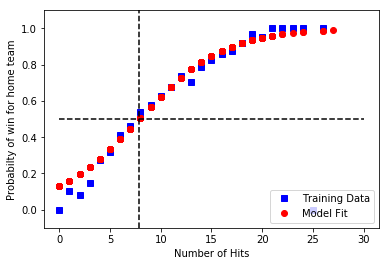

In [137]:
plt.plot(hits_range, prob_est_train_data, 'bs', label='Training Data')
plt.plot(train_num_hits, prob_est_model[:, 1], 'ro', label='Model Fit')
plt.plot([0, 30], [0.5,0.5],'k--' )
plt.plot([7.89, 7.89], [-0.1, 1.1], 'k--')
plt.ylim([-0.1,1.1])
plt.legend(loc='lower right')
plt.xlabel('Number of Hits')
plt.ylabel('Probabilty of win for home team')
plt.show()

In [141]:
log_file5 = 'GL2016.TXT'
df5 = pd.read_table(log_file5, sep=',', header=None)

df5.rename(columns = {6:'Home Team', 9:'Runs Visitor', 10:'Runs Home', 50:'Hits Home'}, inplace=True)

df5['Home Win'] = (df5['Runs Home'] > df5['Runs Visitor'])

test_num_hits = df5['Hits Home'].values.reshape([-1,1])
test_win_label = df5['Home Win'].values.reshape([-1,1])

In [142]:
# Assign predictions to varible

predict_win_label2 = log_regr3.predict(test_num_hits)

In [143]:
# calculate prediction score

log_regr3_score_test = log_regr3.score(test_num_hits, test_win_label.ravel())
print('Percentage correct on test set = ', 100. * log_regr3_score_test, '%')

Percentage correct on test set =  66.76276771004942 %


In [145]:
# Evaluate the performanvce of each value of X variable
delta = np.abs(test_win_label.ravel() - predict_win_label2.ravel())
hits_range = np.arange(np.min(test_num_hits), np.max(test_num_hits))
frac_correct = np.zeros([len(hits_range), 1])
for hits in hits_range:
    index_all = np.where(test_num_hits == hits)
    index_correct = np.where((test_num_hits.ravel() == hits) & (delta.ravel() == 0))
    frac_correct[int(hits - np.min(test_num_hits))] = len(index_correct[0]) / len(index_all[0])

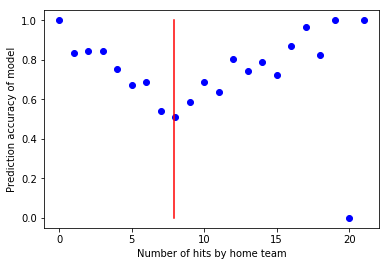

In [147]:
# 

plt.plot(hits_range, frac_correct, 'bo')
plt.xlabel('Number of hits by home team')
plt.ylabel('Prediction accuracy of model')
mid_point = -1. * float(log_regr3.intercept_) / float(log_regr3.coef_)
plt.plot([mid_point, mid_point], [0,1], 'r')
plt.show()